# Tutorial
To learn how to generate a Mahalanobis distance map using a simulated toy image

In [1]:
def Suavizar(array,k_size=(3,3,3)):
    dim = len(k_size)
    mascara, offset, coordenadas = Get_ventana(k_size)
    print(offset,array.shape)
    array_new = np.zeros_like(array)
    if dim ==2:
        offset_axis0,offset_axis1=offset
        array_pad = np.pad(array,pad_width=((offset_axis0,offset_axis0),(offset_axis1,offset_axis1)),mode='edge')
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                i_pad = i+offset_axis0; j_pad = j+offset_axis1
                array_new[i,j] = np.mean(array_pad[i_pad+coordenadas[:,0],j_pad+coordenadas[:,1]])
    elif dim==3:
        offset_axis0,offset_axis1,offset_axis2=offset
        array_pad = np.pad(array,pad_width=((offset_axis0,offset_axis0),(offset_axis1,offset_axis1),(offset_axis2,offset_axis2)),mode='edge')
        for k in range(x.shape[0]):
            for i in range(x.shape[1]):
                for j in range(x.shape[2]):
                    k_pad = k+offset_axis0; i_pad = i+offset_axis1; j_pad = j+offset_axis2
                    array_new[k,i,j] = np.mean(array_pad[k_pad+coordenadas[:,0],i_pad+coordenadas[:,1],j_pad+coordenadas[:,2]])
    return array_new
def Get_ventana(size_mascara):
    offset_axis0 = size_mascara[0]//2
    offset_axis1 = size_mascara[1]//2
    dim = len(size_mascara)
    largo = np.prod(size_mascara)
    coordenadas = np.zeros((largo, dim),dtype=np.int16)
    indice = 0
    if dim==2:
        offset = (offset_axis0,offset_axis1)
        mascara = np.mgrid[0:size_mascara[0], 0:size_mascara[1]]#-offset
        mascara[0] -= offset_axis0
        mascara[1] -= offset_axis1
        for i in range(mascara.shape[1]):# fila
            for j in range(mascara.shape[2]):# columna
                coordenadas[indice] = mascara[:,i,j]
                indice += 1
    elif dim==3:
        offset_axis2 = size_mascara[2]//2
        offset = (offset_axis0,offset_axis1,offset_axis2)
        mascara = np.mgrid[0:size_mascara[0], 0:size_mascara[1], 0:size_mascara[2]]#-offset
        mascara[0] -= offset_axis0
        mascara[1] -= offset_axis1
        mascara[2] -= offset_axis2
        for k in range(mascara.shape[1]):# 1er dimensión corresponde a número de slide
            for i in range(mascara.shape[2]):# fila
                for j in range(mascara.shape[3]):# columna
                    coordenadas[indice] = mascara[:,k,i,j]
                    indice += 1
    return mascara, offset, coordenadas

def Get_canal_caracteristicas_3D(canal_3D, Y_3D, lista_caracteristicas, Xhf,size_hf,niveles_hf):
    canal_caracteristicas = np.zeros([len(lista_caracteristicas)]+list(canal_3D.shape), dtype=np.float32)
    dc = dCaracteristicas(canal_3D, Y_3D, Xhf,size_hf,niveles_hf)# Obtener diccionario pares caracteristica(str):matriz(float)
    for c in range(len(lista_caracteristicas)):
        caracteristica = lista_caracteristicas[c]
        canal_caracteristicas[c] = dc[caracteristica]
    return canal_caracteristicas

def Cuantizar(array, niveles=32, lim_inf_zero=True):
    '''Manera simple de cuantizar'''
    if lim_inf_zero:
        return np.around( (array-array.min())/(array.max()-array.min()) * niveles).astype(np.int16)
    return np.around(array/array.max()*niveles).astype(np.int16)

def dCaracteristicas(X3D, Y3D, Xhf, size_hf=(5,5), niveles_hf = 32):# asumiendo imagen 2D de un solo canal
    d = {}
    dim = len(size_hf)
    if dim==2:
        mascara_hf, offset_hf, coordenadas_hf = Get_ventana(size_hf)
        offset_hf_axis_i, offset_hf_axis_j = offset_hf
        offset_hf_axis_k = 0
        Xhf_pad = np.pad(Xhf, pad_width=((offset_hf_axis_k,offset_hf_axis_k),(offset_hf_axis_i,offset_hf_axis_i),(offset_hf_axis_j,offset_hf_axis_j)),mode='edge')
    elif dim==3:
        mascara_hf, offset_hf, coordenadas_hf = Get_ventana(size_hf)
        offset_hf_axis_k, offset_hf_axis_i, offset_hf_axis_j = offset_hf
        Xhf_pad = np.pad(Xhf, pad_width=((offset_hf_axis_k,offset_hf_axis_k),(offset_hf_axis_i,offset_hf_axis_i),(offset_hf_axis_j,offset_hf_axis_j)),mode='edge')
#     print(f'Xhf_pad:{Xhf_pad.dtype, Xhf_pad.shape, np.unique(Xhf_pad)}')
#     print(f'mascara_hf:{mascara_hf.shape}, offset_hf:{offset_hf}, coordenadas_hf:{coordenadas_hf.shape}')
    hf_ASM = np.zeros(X3D.shape, dtype=np.float32)# (1) ASM or Energy
    hf_contrast = np.zeros(X3D.shape, dtype=np.float32)# (2) Contrast
    hf_correlation = np.zeros(X3D.shape, dtype=np.float32)# (3) Correlation
    hf_homogeneity = np.zeros(X3D.shape, dtype=np.float32)# (5) Homogeneity: Inverse difference moment
    hf_entropy = np.zeros(X3D.shape, dtype=np.float32)# (9) Entropy
    
    d['intensidad'] = np.copy(X3D)
    sdf = np.zeros(Y3D.shape,dtype=np.float32)
    intensidad_media = np.zeros(X3D.shape,dtype=np.float32)
    var = np.zeros(X3D.shape,dtype=np.float32)
    gradh = np.zeros(X3D.shape,dtype=np.float32)
    gradv = np.zeros(X3D.shape,dtype=np.float32)
    laplacian = np.zeros(X3D.shape,dtype=np.float32)
    k_h = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])# libro
    k_v = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])# libro
    k_lpc = np.array([[0,1,0],[1,-4,1],[0,1,0]])# libro
    contador=0
    for k in range(X3D.shape[0]):
        mascara2D, offset2D, coordenadas2D = Get_ventana((3,3))
        X2D = X3D[k]
        Y2D = Y3D[k]
        offset2D_axis_i, offset2D_axis_j = offset2D
        X2D_pad = np.pad(X2D,pad_width=((offset2D_axis_i,offset2D_axis_i),(offset2D_axis_j,offset2D_axis_j)),mode='edge')
#         X2D_pad = np.pad(X2D,pad_width=offset2D,mode='edge')
        sdf[k] = ModuloA.SDF(Y2D)
        for i in range(X3D.shape[1]):
            for j in range(X3D.shape[2]):
                i_pad = i+offset2D_axis_i; j_pad = j+offset2D_axis_j
                intensidades2D = X2D_pad[i_pad+mascara2D[0],j_pad+mascara2D[1]]
                intensidad_media[k,i,j] = np.mean(intensidades2D)
                var[k,i,j] = np.var(intensidades2D)
                gradh[k,i,j] = np.sum(intensidades2D*k_h)/4
                gradv[k,i,j] = np.sum(intensidades2D*k_v)/4
                laplacian[k,i,j] = np.sum(intensidades2D*k_lpc)
                
                k_pad_hf = k+offset_hf_axis_k; i_pad_hf = i+offset_hf_axis_i; j_pad_hf = j+offset_hf_axis_j
                
#                 k_pad_hf = k+offset_hf; i_pad_hf = i+offset_hf; j_pad_hf = j+offset_hf
                if dim==2:
                    intensidades_hf = Xhf_pad[k_pad_hf,i_pad_hf+mascara_hf[0],j_pad_hf+mascara_hf[1]]
                elif dim==3:# si solo se usa slide adyacentes, limitar arreglo 3D intensidades_hf
                    intensidades_hf = Xhf_pad[k_pad_hf+mascara_hf[0],i_pad_hf+mascara_hf[1],j_pad_hf+mascara_hf[2]]
#                 if contador<1:
#                     print(f'dim:{dim},intensidades_hf:{intensidades_hf.shape}\n{intensidades_hf}\n{intensidades_hf[offset_hf]}')
#                 contador+=1
                features = mahotas.features.haralick(intensidades_hf,return_mean=True)
                hf_ASM[k,i,j] = features[0]
                hf_contrast[k,i,j] = features[1]
                hf_correlation[k,i,j] = features[2]
                hf_homogeneity[k,i,j] = features[4]
                hf_entropy[k,i,j] = features[8]
    gradMag = np.sqrt((gradh)**2/2+(gradv)**2/2)
    gradAng = np.arctan2(gradv, gradh)
    d['intensidad_media'] = intensidad_media
    d['varianza'] = var
    d['gradh'] = gradh
    d['gradv'] = gradv
    d['gradMag'] = gradMag
    d['gradAng'] = gradAng
    d['laplacian'] = laplacian
    d['sdf'] = sdf
    d['hf_ASM'] = hf_ASM
    d['hf_contrast'] = hf_contrast
    d['hf_correlation'] = hf_correlation
    d['hf_homogeneity'] = hf_homogeneity
    d['hf_entropy'] = hf_entropy
    return d


(1, 1, 1) (1, 35, 30)
109956.20530319214
ConvergenceWarning!
i,j:(9, 10), mcc:(31, 3)


Text(0.5, 1.0, 'MDF')

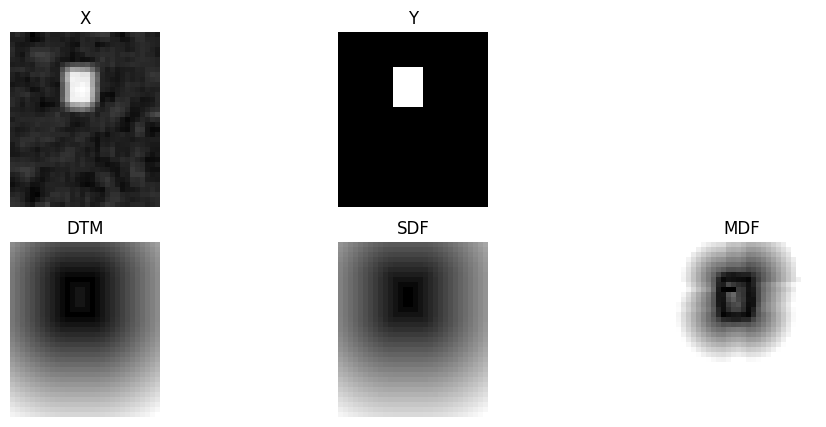

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import find_boundaries
from scipy import ndimage
import ModuloA
import mahotas


# Simulate:
# X: textured image (float32 array)
# Y: Ground-truth (binary array)

# img_size = (1, 25, 30)
img_size = (1, 35, 30)# 1xHxW slides
np.random.seed(20)

mu1, sigma1 = 200, 10 # Hyperintensity
x1 = np.random.normal(mu1, sigma1, img_size).astype(np.float32)
mu2, sigma2 = 100, 15
x2 = np.random.normal(mu2, sigma2, img_size).astype(np.float32)
y = np.zeros(img_size, dtype=np.bool_)
y[0,7:15,11:17] = True # lesion 1
# y[1:5,7:15,11:17] = True # lesion 1
# y[1:7,20:22,21:23] = True # lesion 2
x1 = y*x1
x2 = (1-y)*x2
x = x1+x2
# print(x.shape,x.dtype)
x = Suavizar(x)
print(x.sum())
X = np.copy(x).astype(np.float32)
Y = np.copy(y)
dtm = ModuloA.DTM(Y)
sdf = ModuloA.SDF(Y)

# Generate feature map F (According to the paper)
d_POUT11={'sc':'A5GL11','canal':'FLAIR','r':5,'ady':0,'ce':'GL','par_ce':0.1,'prototipo':'prototipo_mediana','gamma_MDF':1.0,'percentil':0.9,'dist':10,'umbral_cc':4}
parametros_out=d_POUT11
sc = parametros_out['sc']; canal = parametros_out['canal']
r = parametros_out['r']; ady = parametros_out['ady']
ce = parametros_out['ce']; par_ce = parametros_out['par_ce'];par_ce = 0.3
prototipo = parametros_out['prototipo']; gamma_MDF = parametros_out['gamma_MDF']
percentil = parametros_out['percentil']; dist = parametros_out['dist']
umbral_cc = parametros_out['umbral_cc']

# Image features X (For more features, use mahotas and a larger image)
# lista_caracteristicas = ['sdf','intensidad','varianza','gradMag']
# lista_caracteristicas = ['sdf','intensidad','varianza']
feature_list = ['sdf','intensidad','varianza']
niveles_hf = 32
size_hf = (3,5,5)
Xhf = Cuantizar(X, niveles_hf)
AC_input = Get_canal_caracteristicas_3D(X,Y,feature_list,Xhf,size_hf,niveles_hf)
mdf = ModuloA.MDF(Y, AC_input, r,ady,ce,par_ce,prototipo,gamma_MDF,percentil,dist)
# # print(f'mdf:{mdf.shape}')

k=0
plt.figure(figsize=(12,5))
plt.subplot(2,3,1);plt.imshow(X[k],cmap='gray');plt.axis('off');plt.title("X")
plt.subplot(2,3,2);plt.imshow(Y[k],cmap='gray', vmin=0, vmax=1);plt.axis('off');plt.title("Y")
plt.subplot(2,3,4);plt.imshow(dtm[k],cmap='gray');plt.axis('off');plt.title("DTM")
plt.subplot(2,3,5);plt.imshow(sdf[k],cmap='gray');plt.axis('off');plt.title("SDF")
plt.subplot(2,3,6);plt.imshow(mdf,cmap='gray');plt.axis('off');plt.title("MDF")

Text(0.5, 1.0, 'SDF')

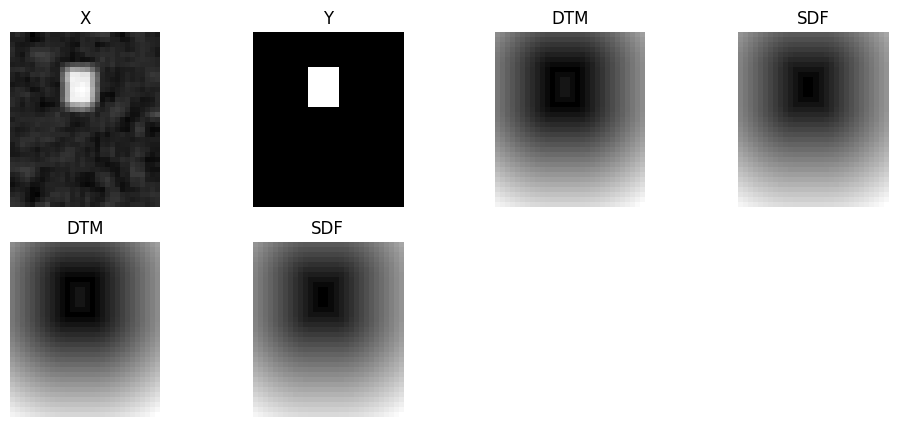

In [15]:
import Biblioteca_General as bbg
dtm_1 = ModuloA.DTM(Y)
sdf_1 = ModuloA.SDF(Y)
dtm_2 = bbg.DTM(Y)
sdf_2 = bbg.SDF(Y)

k=0
plt.figure(figsize=(12,5))
plt.subplot(2,4,1);plt.imshow(X[k],cmap='gray');plt.axis('off');plt.title("X")
plt.subplot(2,4,2);plt.imshow(Y[k],cmap='gray', vmin=0, vmax=1);plt.axis('off');plt.title("Y")
plt.subplot(2,4,3);plt.imshow(dtm_2[k],cmap='gray');plt.axis('off');plt.title("DTM")
plt.subplot(2,4,4);plt.imshow(sdf_2[k],cmap='gray');plt.axis('off');plt.title("SDF")
plt.subplot(2,4,5);plt.imshow(dtm_2[k],cmap='gray');plt.axis('off');plt.title("DTM")
plt.subplot(2,4,6);plt.imshow(sdf_2[k],cmap='gray');plt.axis('off');plt.title("SDF")

In [7]:
print(Y.shape)
print(dtm_2.shape)
print(sdf_2.shape)

(1, 35, 30)
(1, 35, 30)
(1, 35, 30)


In [18]:
print(dtm_1.sum())
print(dtm_2.sum())
print(np.array_equal(dtm_1,dtm_2))

print(sdf_1.sum())
print(sdf_2.sum())
print(np.array_equal(sdf_1,sdf_2))

10388.07
10388.07
True
10324.07
10324.07
True
